# Plot the Results

In [1]:
import os
import seaborn as sns
sns.set_theme(style="darkgrid", palette='pastel')
current_palette = sns.color_palette()
from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull

In [2]:
def fine_upperbound(points_x, points_y):
    points = np.array(list(zip(points_x, points_y)))
    hull = ConvexHull(points)
    upper_hull_points = []
    for simplex in hull.simplices:
        for vertex in simplex:
            upper_hull_points.append(points[vertex])
    upper_hull_points = sorted(set(map(tuple, upper_hull_points)))
    return list(zip(*upper_hull_points))

In [3]:
def getlocalmax(x,y,bins = 20):
    x = np.array(x)
    logx = np.log(x)
    y = np.array(y)

    sorted_indices = np.argsort(logx)
    x = x[sorted_indices]
    logx = logx[sorted_indices]
    y = y[sorted_indices]

    x_min, x_max = logx[0], logx[-1]
    bin_width = (x_max - x_min) / bins

    newx = []
    newy = []

    for i in range(bins):
        start = x_min + i * bin_width
        end = start + bin_width
        
        indices = (logx >= start) & (logx < end)
        if np.any(indices):
            max_index = np.argmax(y[indices])
            actual_indices = np.where(indices)[0]
            newx.append(x[actual_indices[max_index]])
            newy.append(y[actual_indices[max_index]])
    return newx, newy

def getlocalmin(x,y,bins = 20):
    x = np.array(x)
    logx = np.log(x)
    y = np.array(y)

    sorted_indices = np.argsort(x)
    x = x[sorted_indices]
    logx = logx[sorted_indices]
    y = y[sorted_indices]

    x_min, x_max = logx[0], logx[-1]
    bin_width = (x_max - x_min) / bins

    newx = []
    newy = []

    for i in range(bins):
        start = x_min + i * bin_width
        end = start + bin_width
        
        indices = (logx >= start) & (logx < end)
        if np.any(indices):
            min_index = np.argmin(y[indices])
            actual_indices = np.where(indices)[0]
            newx.append(x[actual_indices[min_index]])
            newy.append(y[actual_indices[min_index]])
    return newx, newy

In [4]:
def crop(x,y, start, end):
    x = np.array(x)
    y = np.array(y)
    indices = (x >= start) & (x <= end)
    return x[indices], y[indices]

In [5]:
def getresults(lines):
    results = {"KAN":{}, "MLP":{}}
    for line in lines:
        line = line.strip(" \n\t")
        items = line.split(",")
        if ",KAN," in line or ",KAN_Text," in line:
            _,dataset,model,layer_widths,batch_norm,activation_name,batch_size,epochs,learning_rate,seed,kan_bspline_grid,kan_bspline_order,kan_shortcut_name,kan_range,train_acc,test_acc,num_parameter,flops,total_training_time,training_time_per_epoch = items
            if dataset in results["KAN"]:
                pass
            else:
                results["KAN"][dataset] = {}
            key = (layer_widths, kan_bspline_grid,kan_bspline_order,kan_shortcut_name,kan_range)
            if key in results["KAN"][dataset]:
                results["KAN"][dataset][key].append((float(train_acc), float(test_acc), float(num_parameter), float(flops), float(total_training_time), float(training_time_per_epoch)))
            else:
                results["KAN"][dataset][key] = [(float(train_acc), float(test_acc), float(num_parameter), float(flops), float(total_training_time), float(training_time_per_epoch))]
        elif ",MLP," in line or ",MLP_Text," in line:
            _,dataset,model,layer_widths,batch_norm,activation_name,batch_size,epochs,learning_rate,seed,_,train_acc,test_acc,num_parameter,flops,total_training_time,training_time_per_epoch = items
            if dataset in results["MLP"]:
                pass
            else:
                results["MLP"][dataset] = {}
            key = (layer_widths)
            if key in results["MLP"][dataset]:
                results["MLP"][dataset][key].append((float(train_acc), float(test_acc), float(num_parameter), float(flops), float(total_training_time), float(training_time_per_epoch)))
            else:
                results["MLP"][dataset][key] = [(float(train_acc), float(test_acc), float(num_parameter), float(flops), float(total_training_time), float(training_time_per_epoch))]
        else:
            raise ValueError("Unknown model type")
    return results

In [68]:
f = open("../results/results.csv", "r")
lines = f.readlines()
results = getresults(lines)

In [69]:
vision_datasets = ["MNIST", 'EMNIST-Balanced', 'EMNIST-Letters',"FMNIST", "KMNIST",'Cifar10', "Cifar100","SVHN"]

8 10 8


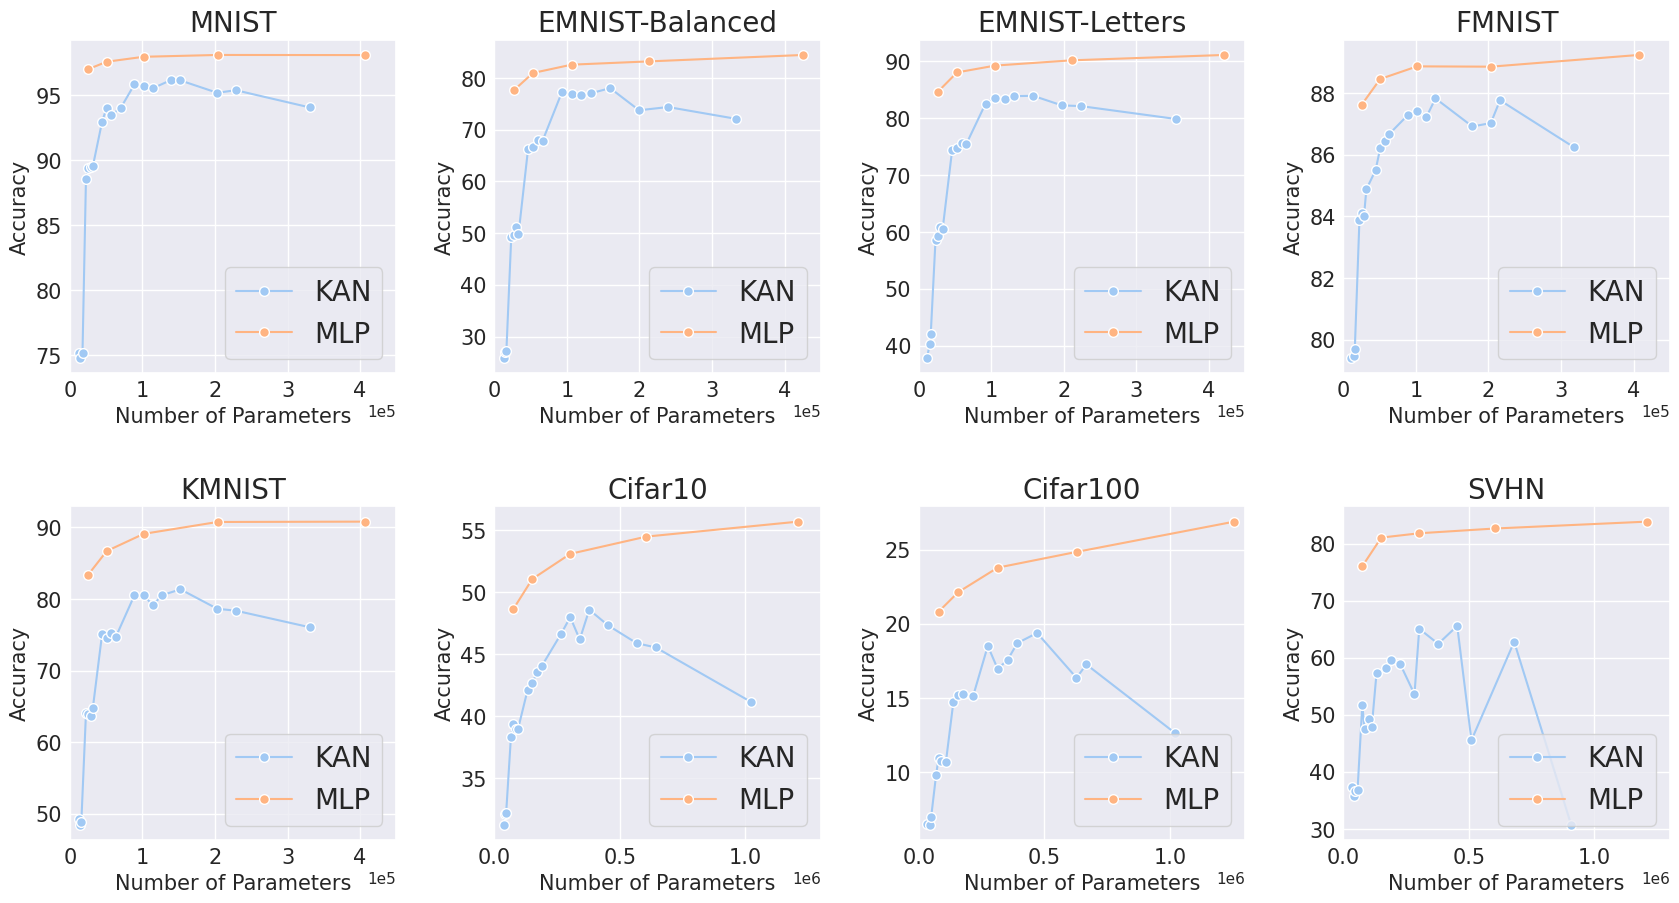

In [31]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.4)

for i, dataset in enumerate(vision_datasets):
    ax = axs[i//4, i%4]
    kan_x, kan_y = [], []
    for items in results["KAN"][dataset].values():
        for item in items:
            kan_x.append(item[2])
            kan_y.append(item[1])
    kan_x, kan_y = getlocalmax(kan_x, kan_y,20)
    mlp_x, mlp_y = [], []
    for items in results["MLP"][dataset].values():
        for item in items:
            mlp_x.append(item[2])
            mlp_y.append(item[1])
    mlp_x, mlp_y = getlocalmax(mlp_x, mlp_y,20)
    ax.plot(kan_x, kan_y, color = current_palette[0], label = "KAN", marker="o", markersize=7, markeredgecolor="white")
    ax.plot(mlp_x, mlp_y, color = current_palette[1], label = "MLP", marker="o", markersize=7, markeredgecolor="white")
    ax.set_title(dataset, fontsize = 20)
    ax.set_xlabel("Number of Parameters",fontsize = 15)
    ax.set_ylabel("Accuracy",fontsize = 15)
    ax.tick_params('y', length = 2, width = 0, labelsize = 15)
    ax.tick_params('x', length = 2, width = 0, labelsize = 15)

    if dataset in ["MNIST", 'EMNIST-Balanced', 'EMNIST-Letters',"FMNIST", "KMNIST"]:
        ax.set_xlim(0, 4.5e5)
    else:
        ax.set_xlim(0, 1.3e6)

    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    ax.legend(loc="lower right", fontsize = 20)

plt.show()
fig.savefig(f"imgs/vision_num_parameter.pdf",  format='pdf',  bbox_inches='tight')

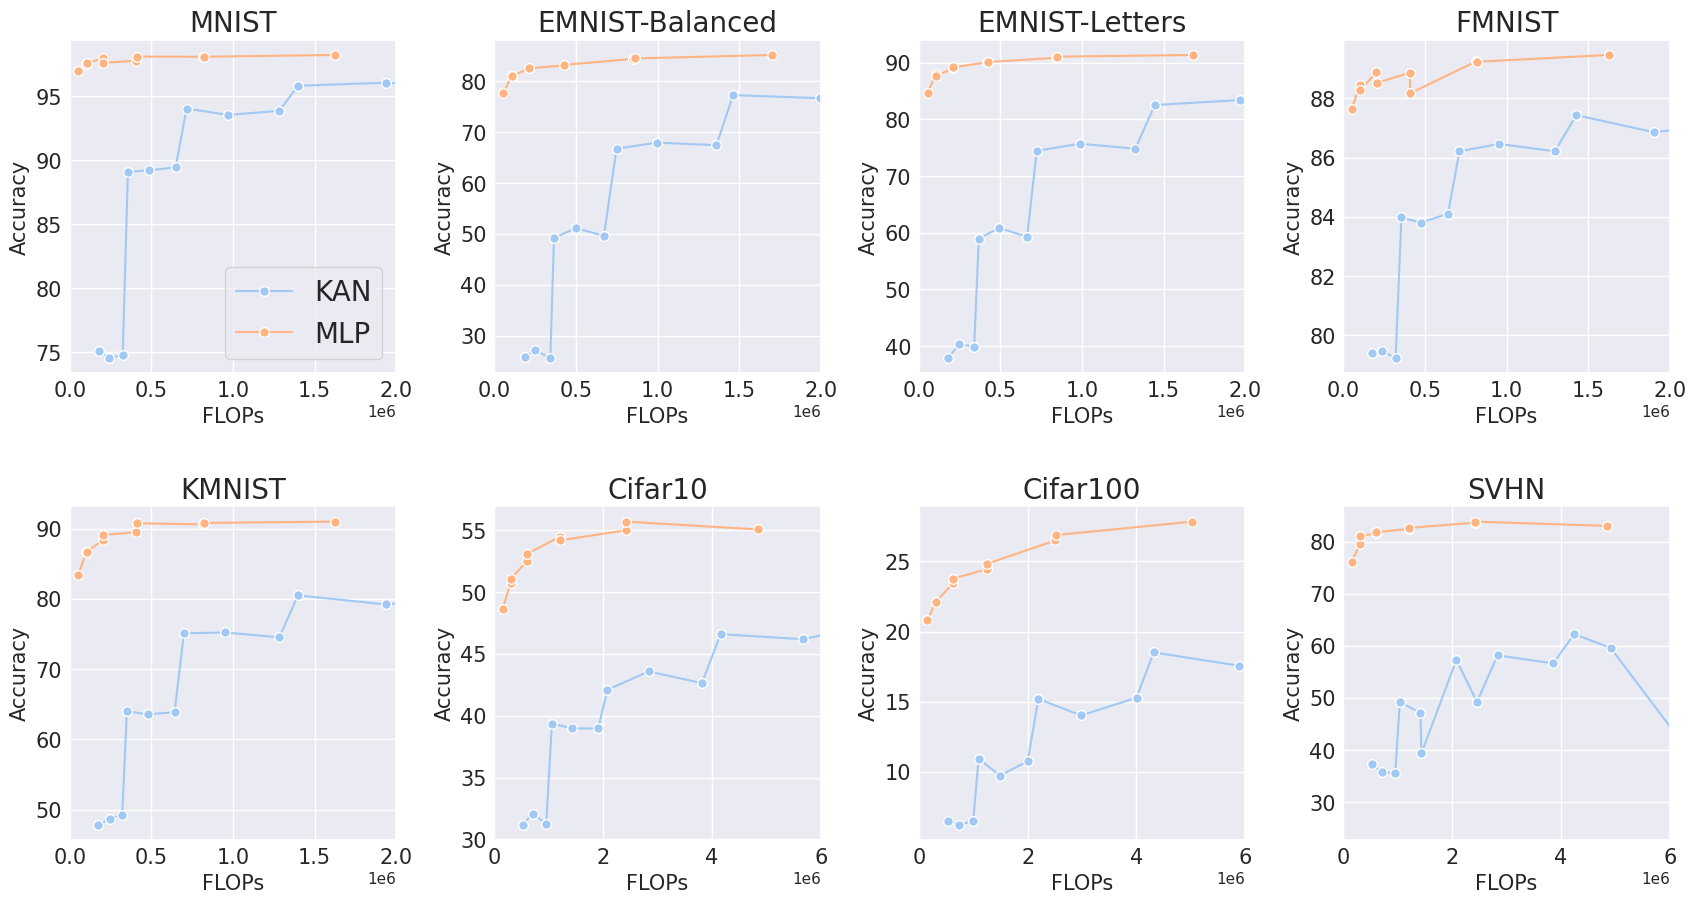

In [32]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.4)

for i, dataset in enumerate(vision_datasets):
    ax = axs[i//4, i%4]
    kan_x, kan_y = [], []
    for items in results["KAN"][dataset].values():
        for item in items:
            kan_x.append(item[3])
            kan_y.append(item[1])
    kan_x, kan_y = getlocalmax(kan_x, kan_y,20)
    mlp_x, mlp_y = [], []
    for items in results["MLP"][dataset].values():
        for item in items:
            mlp_x.append(item[3])
            mlp_y.append(item[1])
    mlp_x, mlp_y = getlocalmax(mlp_x, mlp_y,20)
    ax.plot(kan_x, kan_y, color = current_palette[0], label = "KAN", marker="o", markersize=7, markeredgecolor="white")
    ax.plot(mlp_x, mlp_y, color = current_palette[1], label = "MLP", marker="o", markersize=7, markeredgecolor="white")  
    ax.set_title(dataset, fontsize = 20)
    ax.set_xlabel("FLOPs",fontsize = 15)
    ax.set_ylabel("Accuracy",fontsize = 15)
    ax.tick_params('y', length = 2, width = 0, labelsize = 15)
    ax.tick_params('x', length = 2, width = 0, labelsize = 15)

    if dataset in ["MNIST", 'EMNIST-Balanced', 'EMNIST-Letters',"FMNIST", "KMNIST"]:
        ax.set_xlim(0, 2e6)
    else:
        ax.set_xlim(0, 6e6)

    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

axs[0,0].legend(fontsize = 20)

plt.show()
fig.savefig(f"imgs/vision_flops.pdf",  format='pdf',  bbox_inches='tight')